### Deep Convolutional Generative Adversarial Network (DCGAN)

![](https://www.tensorflow.org/tutorials/generative/images/gan1.png)

Reference: [TF: Deep Convolutional Generative Adversarial Network (DCGAN) ](https://www.tensorflow.org/tutorials/generative/dcgan)

Dataset: `MNIST` Dataset from Keras

![](https://www.tensorflow.org/tutorials/generative/images/gan2.png)

In [2]:
# To generate GIFs
! pip install imageio
! pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-5fdahxe3
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-5fdahxe3
  Resolved https://github.com/tensorflow/docs to commit 97ac0aea73f1cf802004049f92bd3a985010d7e5
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.9.4.19335-py3-none-any.whl size=184104 sha256=ebc8faf0c9e96d01a8d0f038299980161307e96d390edf158aafd52593555e77
  Stored in directory: /tmp/pip-ephem-wheel-cache-v_8wjs6t/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time

from IPython import display

### Load and Prepare Dataset

In [6]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [7]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [9]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [16]:
for image_batch in train_dataset.take(2):   # 2 batches with 256 samples (28x28x1)
  print("Dataset shape:", image_batch.shape)

Dataset shape: (256, 28, 28, 1)
Dataset shape: (256, 28, 28, 1)


In [17]:
DISP_IMG_ROW = 6  # Total displayed images for each row
DISP_IMG_COL = 6  # Total displayed images for each column

In [18]:
def display_images(dataset, figsize=(6,6), denormalize=False):
    img_list = []
    fig, axes = plt.subplots(DISP_IMG_ROW, DISP_IMG_COL, sharex=True, sharey=True, figsize=figsize,)

    for image_batch in dataset.take(1):  # Get first batch of the dataset
        img_list.append(image_batch)  # (1, 64, 32, 32, 3) => (NUM_BATCH, BATCH_SIZE, WIDTH, HEIGHT, CHANNEL)

    img_list = np.array(img_list)   # (1, 64, 32, 32, 3)
    img_list = np.squeeze(img_list)  # reduce 1 dimension: (64, 32, 32, 3)

    for ix, ax in enumerate(axes.flatten()):
        # img = img_list[ix,:,:,:]
        img = img_list[ix]
        if denormalize:
            img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8) # Scale back to 0-255
        ax.imshow(img, aspect='equal')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    plt.subplots_adjust(wspace=0, hspace=0)

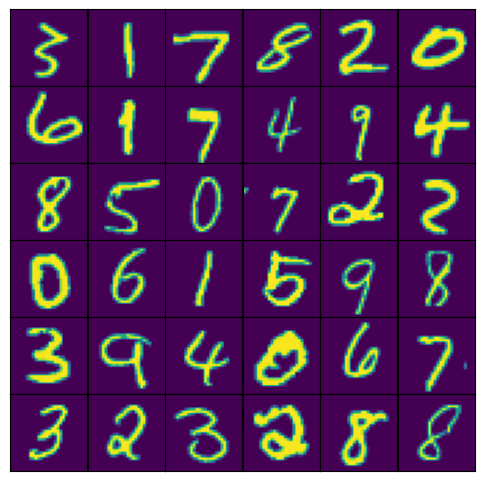

In [19]:
display_images(train_dataset)

### Generator

The network has `4 convolutional layers`. All followed by batch normalization `BN` (except for the output layer) and Rectified Linear unit (`ReLU`) activations. It takes as input a `random vector z` (drawn from a normal distribution). After reshaping z to have a 4D shape, we feed it to the generator that starts a series of upsampling layers.

Each upsampling layer represents a `transpose convolution` operation with `strides 2`. Basically, every time we move the convolutional kernel by one pixel on the input feature map, we move it by 2 or more pixels on the output map.

After each transpose convolution, z becomes wider and shallower. All transpose convolutions use a `5x5 kernel’s` size with depths reducing from `512` all the way down to `3` - representing an RGB color image.

The final layer outputs a `32x32x3` tensor squashed between values of `-1` and `1` through the Hyperbolic Tangent (`tanh`) function. Finally, we scale the input data to the interval of -1 to 1 to follow the choice of using the tanh function.

In [20]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

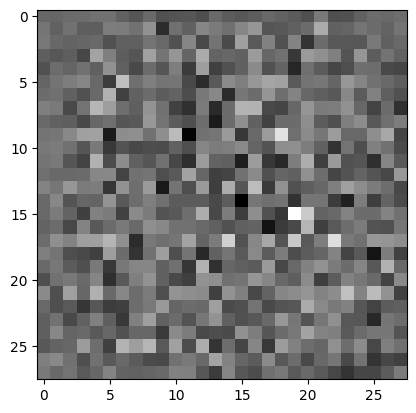

In [21]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminator

The discriminator acts as a regular `binary classifier`. Half of the time it receives images from the training set and the other half from the generator. The discriminator notices a difference between the real and fake images, it sends a signal to the generator. This signal is the gradient that flows from the discriminator to the generator. By receiving it, the generator is able to adjust its parameters to get closer to the true data distribution. We want the discriminator to be able to distinguish between real and fake images. `Every` time we run a mini-`batch` through the `discriminator`, we get `logits`. These are the `unscaled values` from the model. However, we can divide the mini-batches that the discriminator receives in `two types`. The First, composed only with `real images` that come from the training set and the second, with only `fake images` a.k.a. the ones created by the generator.

In [22]:
generated_image.shape[1:]

TensorShape([28, 28, 1])

In [23]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [24]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00157361]], shape=(1, 1), dtype=float32)


### Training [DCGAN model](https://arxiv.org/abs/1511.06434)

Because both networks train at the same time, GANs also need `two optimizers`. Each one for `minimizing` the `discriminator and generator’s loss` functions respectively. We want the discriminator to output probabilities close to `1` for `real` images and near `0` for `fake` images. To do that, the discriminator needs two losses. Therefor, the total loss for the discriminator is the `sum of these two partial losses`. One for maximizing the probabilities for the real images and another for minimizing the probability of fake images.


In the beginning discriminator receives `two` very `distinct` types of `batches`. One, composed of `true images` from the training set and another containing very `noisy signals`. As training progresses, the generator starts to output images that look closer to the images from the training set. At the same time, the discriminator starts to get real good at classifying samples as real or fake. As a consequence, the two types of mini-batches begin looking similar, in structure, to one another.

In this paper, `vanilla cross-entropy` with `Adam` was used as optimizer for the losses.

### Define Loss and Optimizers

In [25]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [26]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [27]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Optimizers

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save Checkpoint

In [30]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Training Loop

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [31]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
seed.shape

### Train step function

In [32]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### Generate and Save Images

In [33]:
def generate_and_save_images(model, epoch, test_input):
  # `training` is set to False.
  predictions = model(test_input, training=False)  # Inference mode

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')  # denormalize
      plt.axis('off')   # No axis, show only image

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [34]:
import time

def train(dataset, epochs):
  for epoch in range(epochs):
    start_time = time.time()   # Get time value for calculating spent time during training

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start_time))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

### Train the model

Call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits.

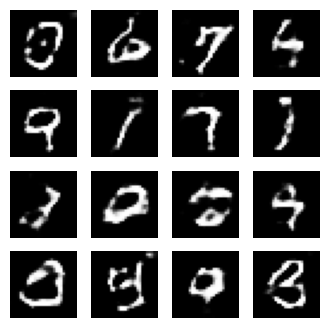

In [35]:
train(train_dataset, EPOCHS)

### Restore the checkpointed values to the `model` object.

In [36]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Create a GIF

In [37]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

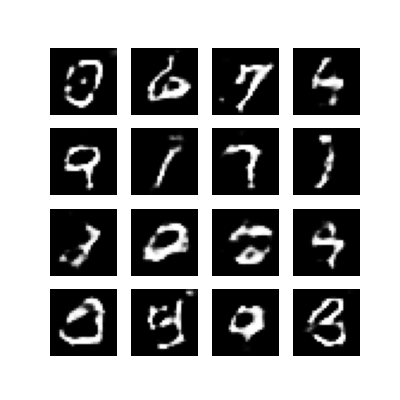

In [38]:
display_image(EPOCHS)

In [39]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)  # append image data to the animation file
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-39-474cf1bce8c5>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-39-474cf1bce8c5>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



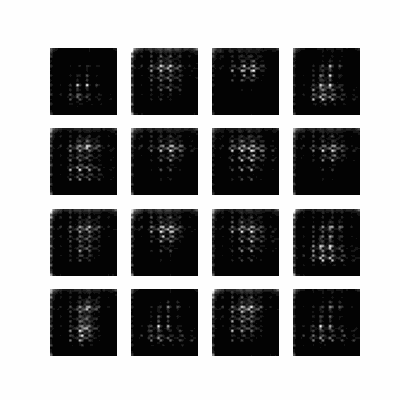

In [41]:
import tensorflow_docs.vis.embed as embed

embed.embed_file(anim_file)

### Reference

https://sthalles.github.io/intro-to-gans/

https://www.tensorflow.org/tutorials/generative/dcgan

[Deep Convolutional Generative Adversarial Network (DCGAN)](https://arxiv.org/abs/1511.06434)

https://github.com/sthalles/blog-resources/blob/master/dcgan/DCGAN.ipynb

Dataset: http://ufldl.stanford.edu/housenumbers/

Citation:

@article{
  silva2017GANs,
  title={A Short Introduction to Generative Adversarial Networks},
  author={Silva, Thalles Santos},
  journal={https://sthalles.github.io},
  year={2017},
  url={https://sthalles.github.io/intro-to-gans/}
}